<a href="https://colab.research.google.com/github/alisonmitchell/Biomedical-Knowledge-Graph/blob/main/02_Exploratory_Data_Analysis/Modelling_K-means_clustering.ipynb"
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg"
      alt="Open in Colab">
</a>

# Modelling - K-means clustering

## 1. Introduction

One practical application for embeddings after dimensionality reduction is the downstream task of clustering. Clustering is an unsupervised learning technique for discovering latent structural patterns in unlabelled data using features to organise instances into distinct groups. It should hopefully reveal something about the underlying class separation in the data.

We will apply K-means - one of the most basic clustering algorithms - implemented by scikit-learn's `KMeans()` class.

## 2. Install/import libraries

In [ ]:
!pip install chart-studio yellowbrick

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
import chart_studio.plotly as py
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer
from chart_studio.plotly import plot, iplot
from mpl_toolkits.mplot3d import Axes3D

from gensim.models import Word2Vec

from embetter.text import SentenceEncoder
from embedding_explorer import show_network_explorer
from embedding_explorer import show_clustering

## 3. 2D t-SNE - scaled data

The total number of clusters you expect should be small enough (otherwise there is no clustering) but large enough so that inertia can be reasonable. Inertia measures the typical distance between a data point and the centre of its cluster.

We will use the two dimensional t-SNE data for clustering with scikit-learn's `KMeans()` class to compute cluster centres and predict cluster indices for the first and second PCA projections.

In [ ]:
# load 2D t-SNE data
with open('2024-09-07_tsne2_df.pickle', 'rb') as f:
  tsne2_df = pickle.load(f)

In [ ]:
def cluster(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(tsne2_df)
    Z = kmeans.predict(tsne2_df)
    return kmeans, Z

In [ ]:
# load scaled TF-IDF data
with open('2024-09-05_scaled_df_tfidf.pickle', 'rb') as f:
  scaled_df_tfidf = pickle.load(f)

In [ ]:
max_clusters = len(scaled_df_tfidf)

In [ ]:
max_clusters

20

In [ ]:
inertias = np.zeros(max_clusters)

for i in range(1, max_clusters):
    kmeans, Z = cluster(i)
    inertias[i] = kmeans.inertia_

### 3.1 Elbow method

To find the optimal value for *k* we will plot inertia as a function of clusters *k* and look for the "elbow" in the curve after which point the inertia decreases much more slowly as we increase *k*.

However, this method does not work well if the data is not very clustered.







In [ ]:
data_km = go.Scatter(
            x=list(range(1, max_clusters)),
            y=inertias[1:]
    )

layout_km = go.Layout(
    title='2D t-SNE - Elbow method',
    xaxis=go.layout.XAxis(title='Number of clusters',
                   range=[0, max_clusters]),
    yaxis=go.layout.YAxis(title='Inertia')
)

fig0 = go.Figure(data=data_km, layout=layout_km)

In [ ]:
pyo.plot(fig0, filename='tsne2-article-text-clustering-inertias')

'tsne2-article-text-clustering-inertias.html'

In [ ]:
fig0.show(renderer="colab", filename='tsne2-article-text-clustering-inertias')

It is not always easy to identify the inflection point to determine the correct value for *k* with the elbow method. We will try k=6 although this may be too high as it will produce very small clusters. However, a lot more samples would be required to test this properly.

### 3.2 Silhouette Plot - 6 clusters

Another technique for choosing the best value for *k* is the silhouette coefficient which is used when the ground truth about the dataset is unknown, and computes the density of clusters computed by the model.

We will use Yellowbrick's [`SilhouetteVisualizer()`](https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html) to display the silhouette coefficient for each sample on a per-cluster basis, visualising cluster density.



In [ ]:
n_clusters = 6
model, Z = cluster(n_clusters)

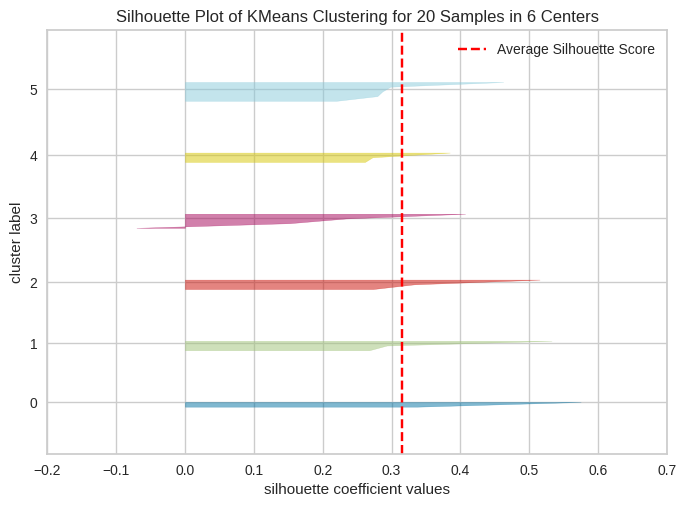

In [ ]:
# Instantiate the clustering model and visualiser
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
# Fit the data to the visualiser and display the plot
visualizer.fit(tsne2_df)
visualizer.show();

Cluster size is indicated by vertical thickness - in the example above the clusters are not very dense. The dashed line is the global average score and is between -1 and 1 where 1 is highly dense, 0 is overlapping and -1 is completely incorrect clustering. The higher the score the better, because the clusters are denser and more separated.

If most of the instances in a cluster stop short of the dashed line this indicates that they have a lower coefficient than this score and the cluster is bad as its instances are too close to other clusters. This is not the case here as all instances extend beyond the dashed line.

Here the average silhouette coefficient is ~0.32 which means clusters are separated but not highly dense.

### 3.3 Scatterplot t-SNE and K-means clustering with 6 clusters

In [ ]:
with open('2024-03-02_pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.pickle', 'rb') as f:
  pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test = pickle.load(f)

In [ ]:
# Define text values for each data point
text_values = [f'{i}: {title}' for i, title in zip((scaled_df_tfidf).index, pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]

# Create Scatter trace for data points
trace0 = go.Scatter(
    x=tsne2_df['t-SNE1'],
    y=tsne2_df['t-SNE2'],
    text=text_values,
    mode='markers',
    marker=dict(
        color=Z,
        size=10,
        opacity=0.8,
        line=dict(
            color='black',
            width=1,
        )
    ),
    name='Data Points',
)

# Create Scatter trace for cluster centres
trace1 = go.Scatter(
    x=model.cluster_centers_[:, 0],
    y=model.cluster_centers_[:, 1],
    name='Cluster Centres',
    mode='markers',
    marker=dict(
        symbol='x',
        size=12,
        color='black',
    ),
)



In [ ]:
# Define data
data = [trace0, trace1]

# Define layout
layout = go.Layout(
    title='Scatterplot t-SNE and k-means clustering with 6 clusters',
    xaxis=dict(title='t-SNE 1'),
    yaxis=dict(title='t-SNE 2'),
    legend=dict(
        font=dict(size=12),
        bordercolor='black',
        borderwidth=1,
    )
)


In [ ]:
# Create figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()

As expected we can see that the six clusters are separated but not highly dense.

### 3.4 Silhouette scores

We will calculate the silhouette scores for all instances in the dataset, and the labels they were assigned, by using scikit-learn's `silhouette_score()` function. Label here refers to the index of the cluster that an instance gets assigned to by the K-means algorithm.



In [ ]:
with open('2024-09-07_tsne2_df.pickle', 'rb') as f:
  tsne2_df = pickle.load(f)

We will calculate silhouette scores for the range 2 to 19 since we only have 20 samples. Choosing the highest score for *k* might yield better results.

In [ ]:
silhouette_scores = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k,
                    random_state=42,
                    n_init = 'auto').fit(tsne2_df)
    kmeans_labels = kmeans.labels_
    silhouette_scores.append(
        {
            'k': k,
            'silhouette_score': silhouette_score(tsne2_df,
                kmeans_labels, metric = 'cosine')
        }
    )

fig = px.line(pd.DataFrame(silhouette_scores).set_index('k'),
       title = '<b>Silhouette scores for K-means clustering</b>',
       labels = {'value': 'silhouette score'},
       color_discrete_sequence = px.colors.qualitative.Alphabet)
fig.update_layout(showlegend = False)

fig.show()

The silhouette score reaches a maximum when k=3 at ~0.53

### 3.5 Silhouette Plot - 3 clusters

We will use the `SilhouetteVisualizer()` to visualise three clusters.

In [ ]:
def cluster(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(tsne2_df)
    Z = kmeans.predict(tsne2_df)
    return kmeans, Z

In [ ]:
n_clusters = 3
model, Z = cluster(n_clusters)

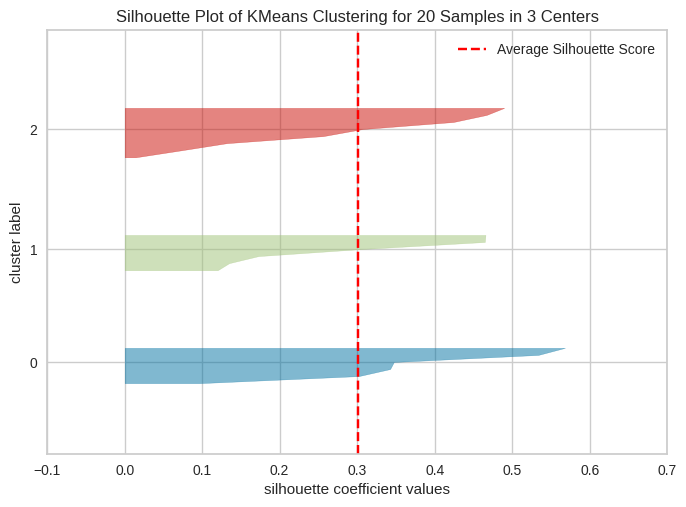

In [ ]:
# Instantiate the clustering model and visualiser
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
# Fit the data to the visualiser and display the plot
visualizer.fit(tsne2_df)
visualizer.show();

This time the average silhouette coefficient is actually slightly lower at 0.3 and the vertical thickness of the clusters is greater, inevitably, as we have fewer but larger clusters.

### 3.6 Scatterplot t-SNE and K-means clustering with 3 clusters

In [ ]:
# Define text values for each data point
text_values = [f'{i}: {title}' for i, title in zip((scaled_df_tfidf).index, pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]

# Create Scatter trace for data points
trace0 = go.Scatter(
    x=tsne2_df['t-SNE1'],
    y=tsne2_df['t-SNE2'],
    text=text_values,
    mode='markers',
    marker=dict(
        color=Z,
        size=10,
        opacity=0.8,
        line=dict(
            color='black',
            width=1,
        )
    ),
    name='Data Points',
)

# Create Scatter trace for cluster centres
trace1 = go.Scatter(
    x=model.cluster_centers_[:, 0],
    y=model.cluster_centers_[:, 1],
    name='Cluster Centres',
    mode='markers',
    marker=dict(
        symbol='x',
        size=12,
        color='black',
    ),
)



In [ ]:
# Define data
data = [trace0, trace1]

# Define layout
layout = go.Layout(
    title='Scatterplot t-SNE and k-means clustering with 3 clusters',
    xaxis=dict(title='t-SNE 1'),
    yaxis=dict(title='t-SNE 2'),
    legend=dict(
        font=dict(size=12),
        bordercolor='black',
        borderwidth=1,
    )
)


In [ ]:
# Create figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()

## 4. 2D PCA - scaled data

We will repeat the process using the two dimensional PCA data.

In [ ]:
with open('2024-09-06_pca2_df.pickle', 'rb') as f:
  pca2_df = pickle.load(f)

In [ ]:
def cluster(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pca2_df)
    Z = kmeans.predict(pca2_df)
    return kmeans, Z

In [ ]:
max_clusters = len(scaled_df_tfidf)

In [ ]:
max_clusters

20

In [ ]:
inertias = np.zeros(max_clusters)

for i in range(1, max_clusters):
    kmeans, Z = cluster(i)
    inertias[i] = kmeans.inertia_

In [ ]:
data_km = go.Scatter(
            x=list(range(1, max_clusters)),
            y=inertias[1:]
    )

layout_km = go.Layout(
    title='2D PCA - Elbow method',
    xaxis=go.layout.XAxis(title='Number of clusters',
                   range=[0, max_clusters]),
    yaxis=go.layout.YAxis(title='Inertia')
)

fig1 = go.Figure(data=data_km, layout=layout_km)

In [ ]:
pyo.plot(fig1, filename='pca2-article-text-clustering-inertias')

'pca2-article-text-clustering-inertias.html'

### 4.1 Elbow method

In [ ]:
fig1.show(renderer="colab", filename='pca2-article-text-clustering-inertias')

The elbow is clearly at the point where k=3.

### 4.2 Silhouette Plot - 3 clusters

In [ ]:
n_clusters = 3
model, Z = cluster(n_clusters)

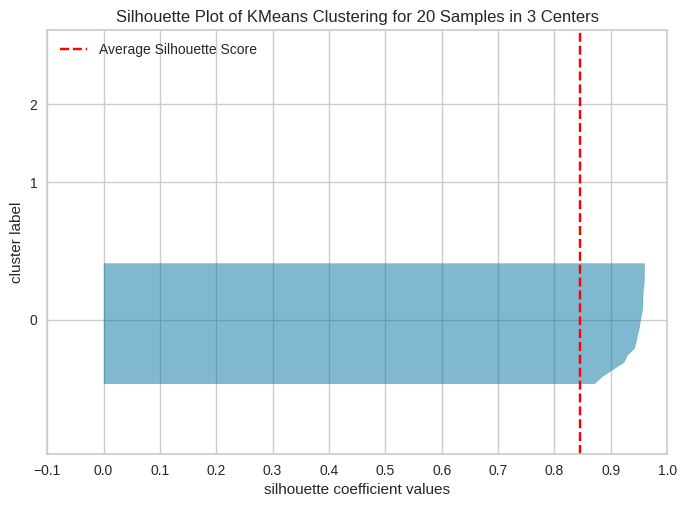

In [ ]:
# Instantiate the clustering model and visualiser
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
# Fit the data to the visualiser and display the plot
visualizer.fit(pca2_df)
visualizer.show();

This is not entirely unexpected given the patterns visualised earlier by the 2D PCA plot. The large cluster has been identified but the two outliers do not count as clusters so do not appear.

### 4.3 Scatterplot PCA and K-means clustering with 3 clusters

In [ ]:
# Define text values for each data point
text_values = [f'{i}: {title}' for i, title in zip(scaled_df_tfidf.index, pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]

# Create Scatter trace for data points
trace0 = go.Scatter(
    x=pca2_df['PC1'],
    y=pca2_df['PC2'],
    text=text_values,
    mode='markers',
    marker=dict(
        color=Z,
        size=10,
        opacity=0.8,
        line=dict(
            color='black',
            width=1,
        )
    ),
    name='Data Points',
)

# Create Scatter trace for cluster centres
trace1 = go.Scatter(
    x=model.cluster_centers_[:, 0],
    y=model.cluster_centers_[:, 1],
    name='Cluster Centres',
    mode='markers',
    marker=dict(
        symbol='x',
        size=12,
        color='red',
    ),
)



In [ ]:
# Define data
data = [trace0, trace1]

# Define layout
layout = go.Layout(
    title='Scatterplot PCA and k-means clustering with 3 clusters',
    xaxis=dict(title='PC 1'),
    yaxis=dict(title='PC 2'),
    legend=dict(
        font=dict(size=12),
        bordercolor='black',
        borderwidth=1,
    )
)


In [ ]:
# Create figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()


PCA is a linear algorithm, whereas most relations are non-linear in real life, and it is also for dense data rather than sparse TF-IDF matrices. It is likely that we were unable to separate the clusters because of non-linearity which is why using t-SNE - a non-linear algorithm suited to sparse matrices - produced better clustering.



## 5. 2D PCA - unscaled data  

We will compare with data from the original TF-IDF matrix without `StandardScaler()` normalisation.

In [ ]:
with open('2024-09-15_pca2_df.pickle', 'rb') as f:
  pca2_unscaled_df = pickle.load(f)

In [ ]:
with open('2024-03-16_df_tfidf.pickle', 'rb') as f:
    df_tfidf = pickle.load(f)

In [ ]:
def cluster(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pca2_unscaled_df)
    Z = kmeans.predict(pca2_unscaled_df)
    return kmeans, Z

In [ ]:
max_clusters = len(df_tfidf)

In [ ]:
max_clusters

20

In [ ]:
inertias = np.zeros(max_clusters)

for i in range(1, max_clusters):
    kmeans, Z = cluster(i)
    inertias[i] = kmeans.inertia_

In [ ]:
data_km = go.Scatter(
            x=list(range(1, max_clusters)),
            y=inertias[1:]
    )

In [ ]:
layout_km = go.Layout(
    title='Article text - Investigate k-means clustering',
    xaxis=go.layout.XAxis(title='Number of clusters',
                   range=[0, max_clusters]),
    yaxis=go.layout.YAxis(title='Inertia')
)

In [ ]:
fig = go.Figure(data=data_km, layout=layout_km)

In [ ]:
pyo.plot(fig, filename='article-text-clustering-inertias')

'article-text-clustering-inertias.html'

### 5.1 Elbow method







In [ ]:

fig.show(renderer="colab", filename='article-text-clustering-inertias')

Again the elbow appears to suggest three clusters.

### 5.2 Silhouette Plot - 3 clusters

In [ ]:
n_clusters = 3
model, Z = cluster(n_clusters)

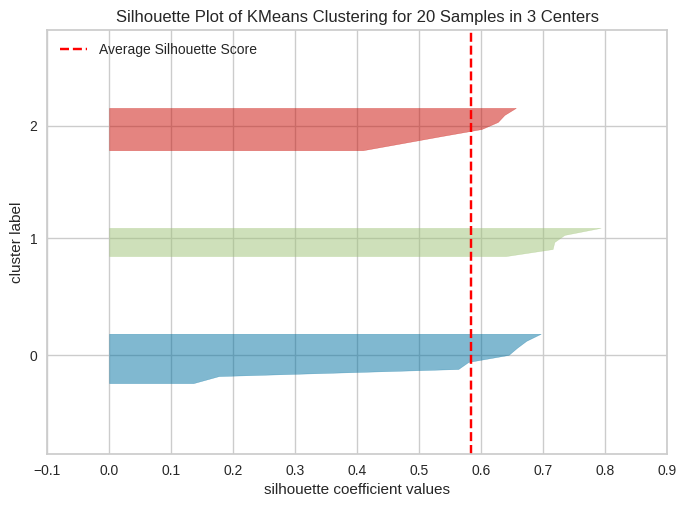

In [ ]:
# Instantiate the clustering model and visualiser
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(pca2_unscaled_df)
visualizer.show();

Not as high an average score as the scaled data which reached ~0.84, but it only had one cluster. Here we have three reasonably even clusters.

### 5.3 Scatterplot PCA and K-means clustering with 3 clusters

In [ ]:
# Define text values for each data point
text_values = [f'{i}: {title}' for i, title in zip(df_tfidf.index, pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]

# Create Scatter trace for data points
trace0 = go.Scatter(
    x=pca2_unscaled_df['PC1'],
    y=pca2_unscaled_df['PC2'],
    text=text_values,
    mode='markers',
    marker=dict(
        color=Z,
        size=10,
        opacity=0.8,
        line=dict(
            color='black',
            width=1,
        )
    ),
    name='Data Points',
)

# Create Scatter trace for cluster centres
trace1 = go.Scatter(
    x=model.cluster_centers_[:, 0],
    y=model.cluster_centers_[:, 1],
    name='Cluster Centres',
    mode='markers',
    marker=dict(
        symbol='x',
        size=12,
        color='black',
    ),
)



In [ ]:
# Define data
data = [trace0, trace1]

# Define layout
layout = go.Layout(
    title='Article Text (PCA and k-means clustering with 3 clusters)',
    xaxis=dict(title='PCA Component 1'),
    yaxis=dict(title='PCA Component 2'),
    legend=dict(
        font=dict(size=12),
        bordercolor='black',
        borderwidth=1,
    )
)

In [ ]:
# Create figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()

Clusters now appear more even in size than the scaled data which had one large cluster and two outliers, although they are not particularly dense.

## 6. Top terms per cluster

We will create a TF-IDF matrix of trigrams for the K-means model to predict clusters and look at the top terms in each cluster.

In [ ]:
def get_tfidf(corpus, ngram_range, max_features=None):
    # create a TfidfVectorizer object to implement the TF-IDF model and fit the data to it
    tfidf = TfidfVectorizer(ngram_range=ngram_range,
                            use_idf=True,
                            smooth_idf=True,
                            max_df=0.85,
                            min_df=0.05,
                            max_features=max_features).fit(corpus)
    # convert data into feature matrix
    X = tfidf.transform(corpus)
    # convert matrix into numpy array
    X_array = tfidf.transform(corpus).toarray()
    # get_feature_names_out() returns the vocabulary of unique words
    features = tfidf.get_feature_names_out()
    return X, X_array, features

In [ ]:
with open('2024-03-02_pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.pickle', 'rb') as f:
    pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test = pickle.load(f)

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     20 non-null     object
 1   published      20 non-null     object
 2   revised        20 non-null     object
 3   title          20 non-null     object
 4   title_cleaned  20 non-null     object
 5   journal        20 non-null     object
 6   authors        20 non-null     object
 7   doi            20 non-null     object
 8   pdf_url        20 non-null     object
 9   text           20 non-null     object
 10  text_cleaned   20 non-null     object
 11  word_count     20 non-null     int64 
 12  sent_count     20 non-null     int64 
dtypes: int64(2), object(11)
memory usage: 2.2+ KB


In [ ]:
X, X_array, features = get_tfidf(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.text_cleaned, (3, 3))

In [ ]:
len(features)

57441

In [ ]:
features

array(['00 97 98', '00 adding ligand', '00 center parameters', ...,
       'μm unwinding 26', 'μm μm respective', 'μm μm sufugolix'],
      dtype=object)

In [ ]:
X

<20x57441 sparse matrix of type '<class 'numpy.float64'>'
	with 59262 stored elements in Compressed Sparse Row format>

### 6.1 K-means - 10 clusters

In [ ]:
number_of_clusters = 10
km = KMeans(n_clusters=number_of_clusters)
km.fit(X)

KMeans(n_clusters=10)

We can access the labels, or indices, of the clusters each instance is assigned to via the `labels_` instance variable.

In [ ]:
km.labels_

array([7, 9, 2, 0, 6, 2, 3, 1, 3, 1, 1, 5, 2, 4, 2, 9, 2, 8, 0, 4],
      dtype=int32)

We will rank the top 10 features (or trigrams) in descending order of importance for each of the 10 clusters.

In [ ]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(number_of_clusters):
    top_ten_words = [features[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_ten_words)}")

Top terms per cluster:
Cluster 0: sars cov main, cov main protease, covid 19 main, 19 main protease, 3d qsar model, non structural proteins, protein sars cov, sars cov virus, covid 19 research, approved marine drugs
Cluster 1: based drug repurposing, drug repurposing studies, genetic risk genes, drug target interactions, clinical trials covid, trials covid 19, drugs covid 19, drug gene covs, gene expression profiles, gene expression data
Cluster 2: covid 19 patients, treatment covid 19, drug like compounds, in vitro in, vitro in vivo, sars cov infection, vero e6 cell, sars cov sequences, drug like compound, broad spectrum antiviral
Cluster 3: nsp 12 sars, rdrp sars cov, 12 sars cov, nsp 12 sofosbuvir, abiraterone cetilistat remdesivir, diiodohydroxyquinoline abiraterone cetilistat, bexarotene diiodohydroxyquinoline abiraterone, domain nsp 12, sars cov rdrp, 12 ribavirin nsp
Cluster 4: sars cov helicase, ph mm nacl, sars cov nsp13, llc new york, mm hepes ph, hepes ph mm, pf 03715455 pf,

order_centroids is an array where each row corresponds to a cluster, and the values in the row are the indices of the features sorted by their importance to that cluster, in descending order.

In [ ]:
# the same length as the number of features in the dataset
len(order_centroids[0])

57441

In [ ]:
texts = pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.text_cleaned

In [ ]:
# create DataFrame of text column and category, or K-means label
results = pd.DataFrame()
results['text'] = texts
results['category'] = km.labels_
results

,text,category
0,sir james black winner nobel prize clearly rec...,7
1,tight selective interaction ligands target pro...,9
2,severe acute respiratory syndrome coronavirus-...,2
3,sudden outbreak sars-cov-2 took world storm de...,0
4,novel coronavirus dubbed sars-cov-2 led global...,6
5,coronavirus disease covid-19 identified decemb...,2
6,covid-19 infectious disease caused coronavirus...,3
7,novel coronavirus cov appeared end wuhan china...,1
8,drug discovery time-consuming costly process i...,3
9,coronavirus disease covid-19 caused severe acu...,1


In [ ]:
with open('2024-03-14_kmeans_results_10_df.pickle', 'wb') as f:
  pickle.dump(results, f)

### 6.2 K-means - 5 clusters

In [ ]:
number_of_clusters = 5
km = KMeans(n_clusters=number_of_clusters)
km.fit(X)

KMeans(n_clusters=5)

In [ ]:
km.labels_

array([4, 0, 3, 0, 4, 2, 1, 4, 1, 4, 4, 4, 4, 0, 2, 1, 2, 4, 0, 1],
      dtype=int32)

In [ ]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(number_of_clusters):
    top_ten_words = [features[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ', '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: sars cov main, cov main protease, sars cov helicase, non structural proteins, sars cov nsp13, ph mm nacl, fda approved drugs, covid 19 main, 19 main protease, protein sars cov
Cluster 1: mol kcal mol, kcal mol kcal, nsp 12 sars, rdrp sars cov, 12 sars cov, binding free energy, nsp 12 sofosbuvir, amino acid residues, kcal mol respectively, abiraterone cetilistat remdesivir
Cluster 2: covid 19 patients, treatment covid 19, drug like compounds, in vitro in, vero e6 cell, sars cov sequences, vitro in vivo, drug like compound, e6 cell line, broad spectrum antiviral
Cluster 3: moderate covid 19, double blind randomised, permits need unauthorized, need unauthorized medicine, based eua permits, vary based eua, authorized product off, blind randomized controlled, eidd 1931 shown, necessary vary based
Cluster 4: based drug repurposing, gene co expression, drug repurposing studies, drug target interactions, genetic risk genes, resnet based cnn, drug repositioning

In [ ]:
results = pd.DataFrame()
results['text'] = texts
results['category'] = km.labels_
results

,text,category
0,sir james black winner nobel prize clearly rec...,4
1,tight selective interaction ligands target pro...,0
2,severe acute respiratory syndrome coronavirus-...,3
3,sudden outbreak sars-cov-2 took world storm de...,0
4,novel coronavirus dubbed sars-cov-2 led global...,4
5,coronavirus disease covid-19 identified decemb...,2
6,covid-19 infectious disease caused coronavirus...,1
7,novel coronavirus cov appeared end wuhan china...,4
8,drug discovery time-consuming costly process i...,1
9,coronavirus disease covid-19 caused severe acu...,4


In [ ]:
with open('2024-03-14_kmeans_results_5_df.pickle', 'wb') as f:
  pickle.dump(results, f)

In [ ]:
# convert TF-IDF matrix into DataFrame
df = pd.DataFrame(X_array, columns=features)
df

,00 97 98,00 adding ligand,00 center parameters,00 statistically significant,001 decay rate,001 licoflavone positive,001 licoflavone reported,001 subjects halted,002 increased advantage,004 deepcda deepdta,...,μm recommended use,μm respective studies,μm sars cov,μm specify dti,μm study wang,μm sufugolix ac50,μm tcep μm,μm unwinding 26,μm μm respective,μm μm sufugolix
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.014637,0.00000,0.00000,0.000000,0.014637
2,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.022282,0.022282,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.00000,0.015656,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
5,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
6,0.000000,0.000000,0.02423,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
7,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.01116,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
8,0.017091,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
9,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000


## 7. Visualising on two dimensions

We will create a TF-IDF matrix for trigrams this time on two dimensions.

In [ ]:
X, X_array, features = get_tfidf(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.text_cleaned, (3, 3), 2)

In [ ]:
# create DataFrame for two dimensional data
df = pd.DataFrame(X_array, columns=features)
df

,covid 19 patients,treatment covid 19
0,0.000000,0.000000
1,0.000000,0.000000
2,0.743831,0.668368
3,0.000000,1.000000
4,1.000000,0.000000
5,0.912169,0.409814
6,0.743831,0.668368
7,0.000000,1.000000
8,0.000000,0.000000
9,0.595848,0.803097


The function has identified 'covid 19 patients' and	'treatment covid 19' as the two most important trigrams in the corpus based on their TF-IDF scores.

In [ ]:
with open('2024-03-14_tfidf_2D_df.pickle', 'wb') as f:
  pickle.dump(df, f)

### 7.1 Scatterplot for two features

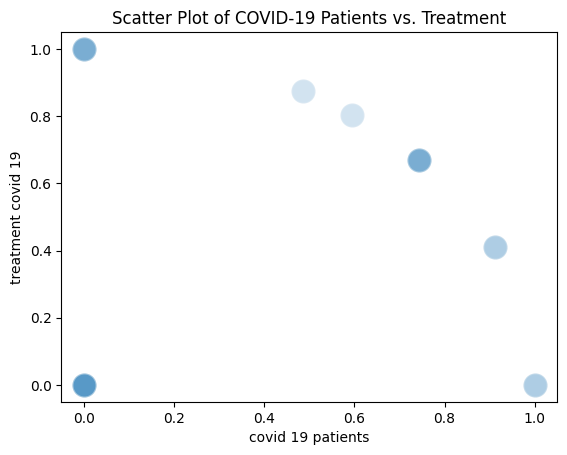

In [ ]:
plt.title('Scatter Plot of COVID-19 Patients vs. Treatment')
sns.scatterplot(data=df, x='covid 19 patients', y='treatment covid 19', alpha=0.2, s=300);

### 7.2 K-means - 3 clusters

In [ ]:
number_of_clusters = 3
km = KMeans(n_clusters=number_of_clusters)
km.fit(X)

In [ ]:
# add labels to DataFrame
df['category'] = km.labels_
df

,covid 19 patients,treatment covid 19,category
0,0.000000,0.000000,1
1,0.000000,0.000000,1
2,0.743831,0.668368,2
3,0.000000,1.000000,0
4,1.000000,0.000000,2
5,0.912169,0.409814,2
6,0.743831,0.668368,2
7,0.000000,1.000000,0
8,0.000000,0.000000,1
9,0.595848,0.803097,2


In [ ]:
with open('2024-03-14_tfidf_2D_labels_df.pickle', 'wb') as f:
  pickle.dump(df, f)

### 7.3 Scatterplot for two features with labels

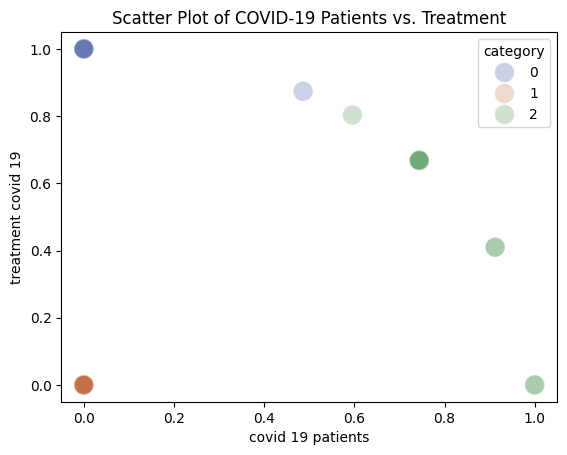

In [ ]:
plt.title('Scatter Plot of COVID-19 Patients vs. Treatment')
sns.scatterplot(data=df, x='covid 19 patients', y='treatment covid 19', alpha=0.2, s=200, hue='category', palette='dark', legend='full')
plt.show()

We will add the title to the DataFrame to use in tooltips on a scatterplot.

In [ ]:
title = pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test['title_cleaned']

In [ ]:
df['title'] = title
df

,covid 19 patients,treatment covid 19,category,title
0,0.000000,0.000000,1,Drug repositioning: A bibliometric analysis.
1,0.000000,0.000000,1,A review on computer-aided chemogenomics and d...
2,0.743831,0.668368,2,Repurposing Molnupiravir as a new opportunity ...
3,0.000000,1.000000,0,Scope of repurposed drugs against the potentia...
4,1.000000,0.000000,2,Drug Repurposing Using Gene Co-Expression and ...
5,0.912169,0.409814,2,Novel Drug Design for Treatment of COVID-19: A...
6,0.743831,0.668368,2,"Repurposing FDA-approved drugs cetilistat, abi..."
7,0.000000,1.000000,0,A comprehensive review of artificial intellige...
8,0.000000,0.000000,1,Structural Homology-Based Drug Repurposing App...
9,0.595848,0.803097,2,Rational drug repositioning for coronavirus-as...


In [ ]:
with open('2024-03-15_tfidf_2D_labels_titles_df.pickle', 'wb') as f:
  pickle.dump(df, f)

### 7.4 Scatterplot for two features with labels and tooltips

In [ ]:
# Define the colour palette
custom_palette = ['#FF5733', '#33FF57', '#337AFF']

# Initialise a dictionary to store titles for each unique (x, y) combination
tooltip_dict = {}

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    # Get the (x, y) values
    xy_values = (row['covid 19 patients'], row['treatment covid 19'])

    # If the (x, y) combination is not in the dictionary, initialize an empty list
    if xy_values not in tooltip_dict:
        tooltip_dict[xy_values] = []

    # Split the title into words
    words = row['title'].split()

    # Concatenate words with <br> after every n words
    wrapped_title = '<br>'.join(' '.join(words[i:i+15]) for i in range(0, len(words), 15))

    # Append the wrapped title to the list
    tooltip_dict[xy_values].append(wrapped_title)

# Create a scatter plot
fig = go.Figure()

# Iterate over the unique categories
for category in range(3):
    # Add the data points for each category
    fig.add_trace(go.Scatter(
        x=df[df['category'] == category]['covid 19 patients'],
        y=df[df['category'] == category]['treatment covid 19'],
        mode='markers',
        marker=dict(
            color=custom_palette[category],  # Colour by category
            size=20,  # Adjust size of data points
            opacity=0.3,  # Set opacity of data points in the plot
            line=dict(
                color='black',
                width=2,
            )
        ),
        name=f'Category {category}',  # Set legend label
        hovertext=['Category: ' + str(category) + '<br>' + '<br>'.join(tooltip_dict[(x, y)]) for x, y in zip(df[df['category'] == category]['covid 19 patients'],
                                                                     df[df['category'] == category]['treatment covid 19'])],
        showlegend=False,  # Hide this trace from the legend
    ))

    # Add an invisible trace for the legend with full opacity
    fig.add_trace(go.Scatter(
        x=[None],  # No actual data point, just for the legend
        y=[None],  # No actual data point, just for the legend
        mode='markers',
        marker=dict(
            color=custom_palette[category],  # Same colour as the actual points
            size=20,  # Same size as the actual points
            opacity=1.0,  # Full opacity in the legend
            line=dict(
                color='black',
                width=2,
            )
        ),
        name=f'Category {category}',  # Legend label
        showlegend=True,  # Show this trace in the legend
    ))

# Show the plot
fig.show()


## 8. Visualising on three dimensions


We will create a TF-IDF matrix for trigrams this time on three dimensions.

In [ ]:
X, X_array, features = get_tfidf(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.text_cleaned, (3, 3), 3)

In [ ]:
features

array(['covid 19 patients', 'fda approved drugs', 'treatment covid 19'],
      dtype=object)

The additional feature identified is 'fda approved drugs'.

In [ ]:
df = pd.DataFrame(X_array, columns=features)
df

,covid 19 patients,fda approved drugs,treatment covid 19
0,0.000000,0.000000,0.000000
1,0.000000,1.000000,0.000000
2,0.743831,0.000000,0.668368
3,0.000000,0.811981,0.583683
4,1.000000,0.000000,0.000000
5,0.912169,0.000000,0.409814
6,0.596827,0.596827,0.536278
7,0.000000,0.894716,0.446636
8,0.000000,0.000000,0.000000
9,0.571044,0.285522,0.769666


### 8.1 K-means - 4 clusters

In [ ]:
number_of_clusters = 4
km = KMeans(n_clusters=number_of_clusters)
km.fit(X)
df['category'] = km.labels_

In [ ]:
df['text'] = texts
df

,covid 19 patients,fda approved drugs,treatment covid 19,category,text
0,0.000000,0.000000,0.000000,3,sir james black winner nobel prize clearly rec...
1,0.000000,1.000000,0.000000,1,tight selective interaction ligands target pro...
2,0.743831,0.000000,0.668368,2,severe acute respiratory syndrome coronavirus-...
3,0.000000,0.811981,0.583683,1,sudden outbreak sars-cov-2 took world storm de...
4,1.000000,0.000000,0.000000,0,novel coronavirus dubbed sars-cov-2 led global...
5,0.912169,0.000000,0.409814,0,coronavirus disease covid-19 identified decemb...
6,0.596827,0.596827,0.536278,2,covid-19 infectious disease caused coronavirus...
7,0.000000,0.894716,0.446636,1,novel coronavirus cov appeared end wuhan china...
8,0.000000,0.000000,0.000000,3,drug discovery time-consuming costly process i...
9,0.571044,0.285522,0.769666,2,coronavirus disease covid-19 caused severe acu...


In [ ]:
with open('2024-03-14_tfidf_3D_df.pickle', 'wb') as f:
  pickle.dump(df, f)

In [ ]:
title = pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test['title_cleaned']

In [ ]:
df['title'] = title
df

,covid 19 patients,fda approved drugs,treatment covid 19,category,text,title
0,0.000000,0.000000,0.000000,3,sir james black winner nobel prize clearly rec...,Drug repositioning: A bibliometric analysis.
1,0.000000,1.000000,0.000000,1,tight selective interaction ligands target pro...,A review on computer-aided chemogenomics and d...
2,0.743831,0.000000,0.668368,2,severe acute respiratory syndrome coronavirus-...,Repurposing Molnupiravir as a new opportunity ...
3,0.000000,0.811981,0.583683,1,sudden outbreak sars-cov-2 took world storm de...,Scope of repurposed drugs against the potentia...
4,1.000000,0.000000,0.000000,0,novel coronavirus dubbed sars-cov-2 led global...,Drug Repurposing Using Gene Co-Expression and ...
5,0.912169,0.000000,0.409814,0,coronavirus disease covid-19 identified decemb...,Novel Drug Design for Treatment of COVID-19: A...
6,0.596827,0.596827,0.536278,2,covid-19 infectious disease caused coronavirus...,"Repurposing FDA-approved drugs cetilistat, abi..."
7,0.000000,0.894716,0.446636,1,novel coronavirus cov appeared end wuhan china...,A comprehensive review of artificial intellige...
8,0.000000,0.000000,0.000000,3,drug discovery time-consuming costly process i...,Structural Homology-Based Drug Repurposing App...
9,0.571044,0.285522,0.769666,2,coronavirus disease covid-19 caused severe acu...,Rational drug repositioning for coronavirus-as...


In [ ]:
with open('2024-03-16_tfidf_3D_text_title_df.pickle', 'wb') as f:
  pickle.dump(df, f)

### 8.2 3D Matplotlib scatterplots as subplots

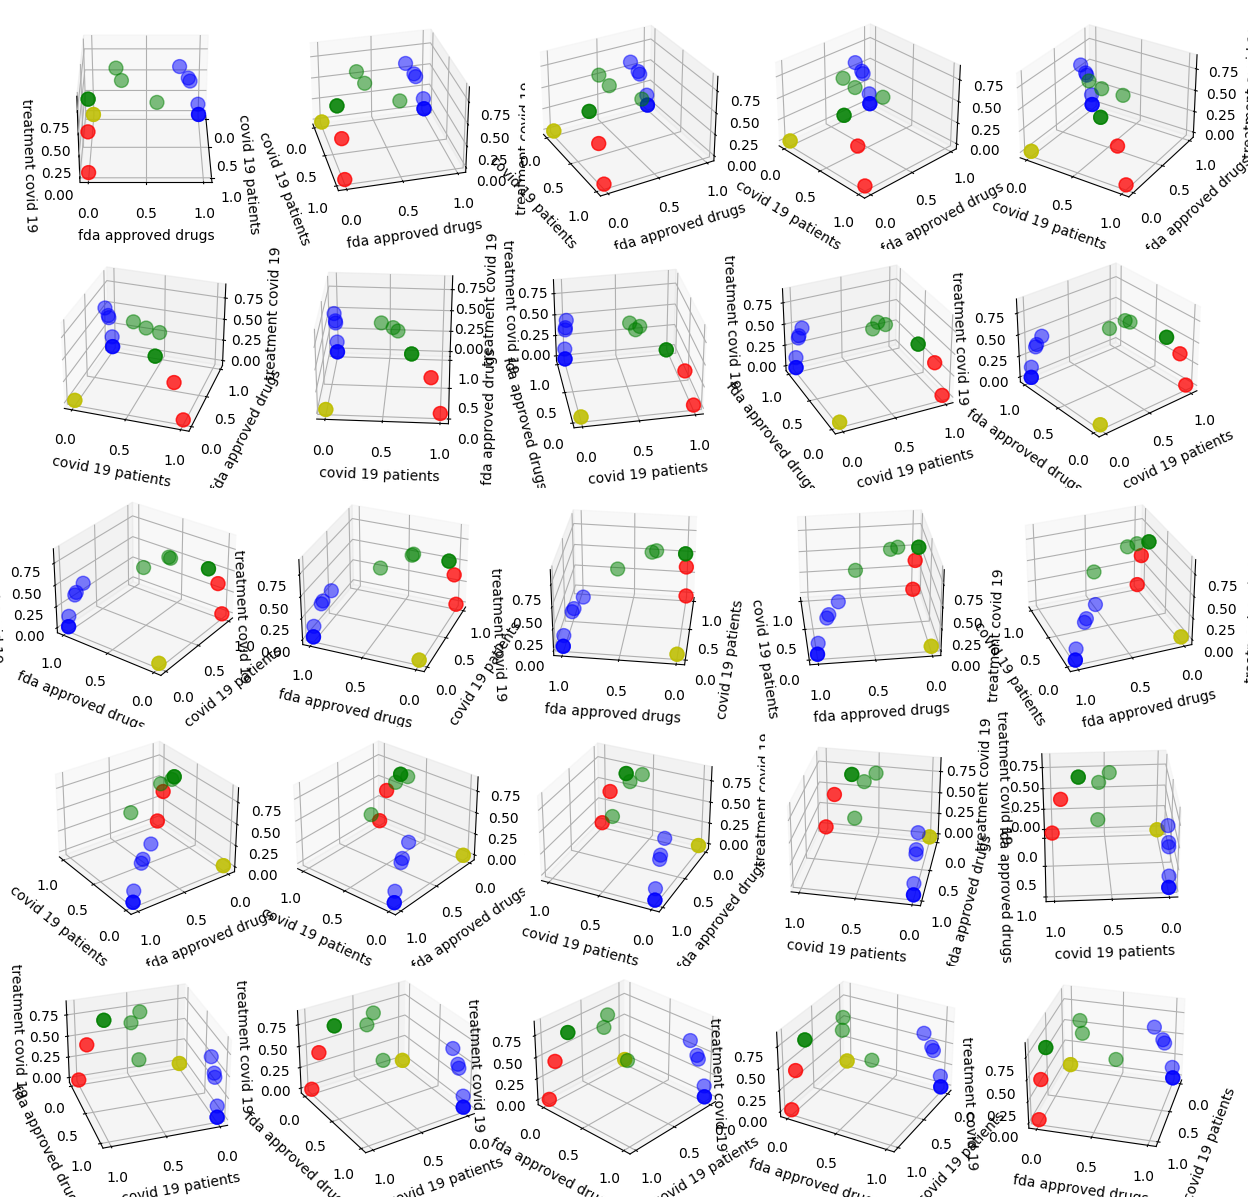

In [ ]:
def draw(ax, df):
    color_list = ['r', 'b', 'g', 'y']
    colors = [color_list[i] for i in df['category']]

    marker_list = ['o', 'x', 'v', 'X']
    markers = [marker_list[i] for i in df['category']]

    ax.scatter(df[features[0]], df[features[1]], df[features[2]], c=colors, s=100, alpha=0.5)
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel(features[2])

chart_count_vert = 5
chart_count_horiz = 5
number_of_graphs = chart_count_vert * chart_count_horiz

fig = plt.figure(figsize=(3 * chart_count_horiz, 3 * chart_count_vert))

for i in range(number_of_graphs):
    ax = fig.add_subplot(chart_count_horiz, chart_count_vert, i + 1, projection='3d', azim=(-360 / number_of_graphs) * i)
    draw(ax, df)

### 8.3 3D plotly scatterplot

In [ ]:
custom_palette = ['#FF5733', '#33FF57', '#337AFF', '#FFC300']

# Initialise a dictionary to store titles for each unique (x, y, z) combination
tooltip_dict = {}

for index, row in df.iterrows():
    # Get the (x, y, z) values
    xyz_values = (row['covid 19 patients'], row['fda approved drugs'], row['treatment covid 19'])  # Assuming 'z_column' is the name of your third column

    # If the (x, y, z) combination is not in the dictionary, initialise an empty list
    if xyz_values not in tooltip_dict:
        tooltip_dict[xyz_values] = []

    # Split the title into words
    words = row['title'].split()

    # Concatenate words with <br> after every n words
    wrapped_title = '<br>'.join(' '.join(words[i:i+15]) for i in range(0, len(words), 15))

    # Append the wrapped title to the list
    tooltip_dict[xyz_values].append(wrapped_title)

# Create a 3D scatter plot
fig = go.Figure()

# Iterate over the unique categories
for category in range(4):
    # Add the data points for each category
    fig.add_trace(go.Scatter3d(
        x=df[df['category'] == category]['covid 19 patients'],
        y=df[df['category'] == category]['fda approved drugs'],
        z=df[df['category'] == category]['treatment covid 19'],
        mode='markers',
        marker=dict(
            color=custom_palette[category],  # Colour by category
            size=5,  # Adjust size of data points
            line=dict(
                color='black',
                width=0.5,
            )
        ),
        name=f'Category {category}',  # Set legend label
        # Set hover text for the data points
        hovertext=['Category: ' + str(category) + '<br>' + '<br>'.join(tooltip_dict[(x, y, z)]) for x, y, z in zip(df[df['category'] == category]['covid 19 patients'],
                                                                     df[df['category'] == category]['fda approved drugs'],
                                                                     df[df['category'] == category]['treatment covid 19'])],
    ))

# Update layout with title, legend, and axis labels
fig.update_layout(
    title='3D Scatter Plot of COVID-19 Patients vs. FDA Approved Drugs vs. Treatment',
    scene=dict(
        xaxis_title='COVID-19 Patients',
        yaxis_title='FDA Approved Drugs',
        zaxis_title='Treatment COVID-19',
    ),
    legend=dict(
        yanchor="top",
        y=.97,
        xanchor="right",
        x=.99,
        bordercolor='black',
        borderwidth=1,
    ),
)

# Show the plot
fig.show()

## References

* Bengfort, B et al. (2018). [Applied Text Analysis with Python](https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/)

* https://towardsdatascience.com/3-d-clustering-of-nba-players-with-plotly-and-k-means-6ee7644f2a6c

* Plotly tutorial https://plotly.com/python/v3/ipython-notebooks/baltimore-vital-signs/

* Yellowbrick https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html

* https://github.com/littlecolumns/ds4j-notebooks/blob/81bbb4a262bf287169a88cd1e6b72dd9c2439eae/text-analysis/notebooks